### Comparing data with other studies
This notebook serves as supplementary comparison to compensate for OIB's localised and limited data.

The data comparing to can be found in '../../snow_ice_thickness'.

Sea ice thickness estimates are obtained from https://zenodo.org/doi/10.5281/zenodo.8366319. This dataset are estimates of sea ice thickness based on the methodology outline in Stroeve et al. (2023): "Mapping potential timing of ice algal blooms from satellite"
Snow thickness are obtained from https://doi.org/10.1029/2019JC015913 and https://doi.org/10.1029/2019JC015900 which utilises SnowModel-LG, a Langrangian snow evolution model.

This would be a good dataset to compare to as the method done also takes input of snow density, air temperature, humidity, wind speed and others which the current rj-MCMC model has yet to consider

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc 
from sklearn.metrics import r2_score

In [2]:

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion


## SNOW

In [3]:
ak = np.load("../carmen/daily_numpys/AK_CPOM/FB_interp_2018-2019_25km_20190406.npy")

inverse_snow_files = ['images/FB_interp_2019_25km_20190406.npy_snow',
                'images/FB_interp_2019_25km_20190412.npy_snow',
                'images/FB_interp_2019_25km_20190419.npy_snow',
                'images/FB_interp_2019_25km_20190420.npy_snow',
                'images/FB_interp_2019_25km_20190422.npy_snow']

# grids
lon_g = np.load("../../new_lon_25km.npy")
lat_g = np.load("../../new_lat_25km.npy")

In [4]:
snow_file = nc.Dataset("/home/sraz/coding/MSCI_2021_Project3/snow_ice_thickness/SMLG_snod_EASE.nc")
snow_06 = snow_file.variables['Snow Depth'][3382, :, :]
snow_12 = snow_file.variables['Snow Depth'][3388, :, :]
snow_19 = snow_file.variables['Snow Depth'][3395, :, :]
snow_20 = snow_file.variables['Snow Depth'][3396, :, :]
snow_22 = snow_file.variables['Snow Depth'][3398, :, :]
snow_file.close()
snow_lg = [snow_06,snow_12,snow_19,snow_20,snow_22]

In [5]:
snow_inverse =[]
snow_compare = []


for i in range(5):
 
    snow_inverse_data = np.loadtxt(inverse_snow_files[i])
    snow_inverse_data = mask_observations(ak,snow_inverse_data)

    for k in range(360):
        for j in range(360):
            if not (snow_lg[i].mask[k][j]) and not np.isnan(snow_inverse_data[k][j]):
                snow_inverse.append(snow_inverse_data[k][j])
                snow_compare.append(snow_lg[i].data[k][j])


In [6]:
# inverse model
error_snow_inverse = np.asanyarray(snow_inverse) - np.asanyarray(snow_compare)
md = np.mean(error_snow_inverse)
md_snow_inverse = f'{md:.2f}m'
rmse = np.sqrt( np.mean( (error_snow_inverse)**2 ))
rmse_snow_inverse = f'{rmse:.2f}m'
r2_snow_inverse = r2_score(snow_compare, snow_inverse)


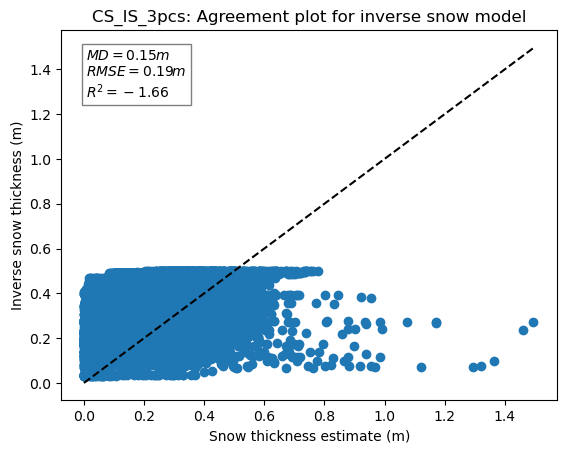

In [7]:
plt.figure()
plt.title('CS_IS_3pcs: Agreement plot for inverse snow model')

plt.scatter(snow_compare, snow_inverse)
plt.plot([0,1.5] , [0,1.5], 'k--')
plt.xlabel('Snow thickness estimate (m)')
plt.ylabel('Inverse snow thickness (m)')


textstr = '\n'.join((
    rf'$MD={md_snow_inverse}$',
    rf'$RMSE={rmse_snow_inverse}$',
    rf'$R^2={r2_snow_inverse:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)


plt.show()

## ICE

In [20]:
inverse_ice_files = ['images/FB_interp_2019_25km_20190406.npy_ice',
                'images/FB_interp_2019_25km_20190412.npy_ice',
                'images/FB_interp_2019_25km_20190419.npy_ice',
                'images/FB_interp_2019_25km_20190420.npy_ice',
                'images/FB_interp_2019_25km_20190422.npy_ice']

ice_CS_file = nc.Dataset("/home/sraz/coding/MSCI_2021_Project3/snow_ice_thickness/CS2_LARM_01102018-30042019.nc")
ice_CS = [ice_CS_file.variables['Sea Ice Thickness'][187, :,:],
          ice_CS_file.variables['Sea Ice Thickness'][193, :,:],
          ice_CS_file.variables['Sea Ice Thickness'][200, :,:],
          ice_CS_file.variables['Sea Ice Thickness'][201, :,:],
          ice_CS_file.variables['Sea Ice Thickness'][203, :,:]]
ice_CS_file.close()

# ice_CS_file = nc.Dataset("/home/sraz/coding/MSCI_2021_Project3/snow_ice_thickness/IS2_01012019-31122019.nc")
# ice_CS = [ice_CS_file.variables['Sea Ice Thickness'][95, :,:],
#           ice_CS_file.variables['Sea Ice Thickness'][101, :,:],
#           ice_CS_file.variables['Sea Ice Thickness'][108, :,:],
#           ice_CS_file.variables['Sea Ice Thickness'][109, :,:],
#           ice_CS_file.variables['Sea Ice Thickness'][111, :,:]]
# ice_CS_file.close()


In [21]:
ice_inverse =[]
ice_compare = []


for i in range(5):
    ice_inverse_data = np.loadtxt(inverse_ice_files[i])
    ice_inverse_data = mask_observations(ak,ice_inverse_data)

    for k in range(360):
        for j in range(360):
            if not (ice_CS[i].mask[k][j]) and not np.isnan(ice_inverse_data[k][j]):
                ice_inverse.append(ice_inverse_data[k][j])
                ice_compare.append(ice_CS[i].data[k][j])


In [22]:
# inverse model
error_ice_inverse = np.asanyarray(ice_inverse) - np.asanyarray(ice_compare)
md = np.mean(error_ice_inverse)
md_ice_inverse = f'{md:.2f}m'
rmse = np.sqrt( np.mean( (error_ice_inverse)**2 ))
rmse_ice_inverse = f'{rmse:.2f}m'
r2_ice_inverse = r2_score(ice_compare, ice_inverse)


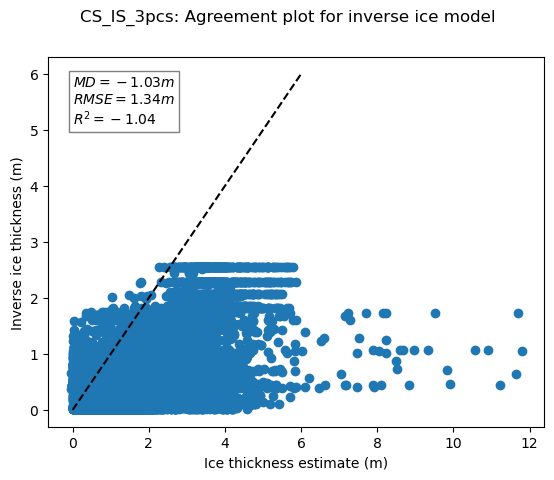

In [23]:
plt.figure()
plt.suptitle('CS_IS_3pcs: Agreement plot for inverse ice model')

plt.scatter(ice_compare, ice_inverse)
plt.plot([0,6] , [0,6], 'k--')
plt.xlabel('Ice thickness estimate (m)')
plt.ylabel('Inverse ice thickness (m)')


textstr = '\n'.join((
    rf'$MD={md_ice_inverse}$',
    rf'$RMSE={rmse_ice_inverse}$',
    rf'$R^2={r2_ice_inverse:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)


plt.show()